## Logistic Matrix Factorization

Binary matrices (Matrices with elements of $0$ or $1$) appear in many applications. A binary matrix can represent relational datasets such as 'User $i$ bought item $j$', or 'Member $i$ likes Member $j$'. Such datasets are often sparse -- only a fraction of the possible entries of a matrix are known. 

A binary matrix $X$ can also viewed as the adjacency matrix of a bipartite graph. Hence each entry $X_{ij}$ in a fully observed matrix $X$ corresponds to the presence (if $X_{ij}=1$) or absence (if $X_{ij}=0$) an edge. However, if 
some entries are unobserved, we are in a situation that we don't know if an edge exists or not. Note that having a missing value is different than the absence of an edge, so we denote such examples with a NaN (not a number) to signal that a value is missing.

One interesting machine learning task here is known as link prediction, writing a program that guesses the presence or absence of edges of a partially observed bipartite graph. This prediction can then be used for several tasks such as recommendation or knowledge-base completion.

### Example: Binary relations

We will introduce first an artificial example -- often called a 'synthetic dataset'

Consider a matrix defined by a boolean valued function $c(i,j)$:
$$
X_{ij} = \left\{\begin{array}{cc} 1 & \text{if}\;c(i,j) \\ 0 & \text{if not}\;c(i,j) \end{array} \right.
$$

Below, we show some examples
\begin{eqnarray}
c_1 & = & (i+j) \mod 2 \\
c_2 & = & j>i \\
c_3 & = & c_1 \vee c_2 \\
c_4 & = & c_1 \wedge c_2 \\
c_5 & = & c_1 \oplus c_2 \\
\end{eqnarray}

You can modify the following code and visualize the different relations.

In [467]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML
from matplotlib import rc


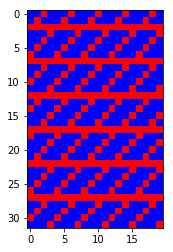

In [536]:
M = 32
N = 20

Y_full = np.zeros((M,N))
for i in range(M):
    for j in range(N):
        
        # condition = (i+j)%3 == 1
        # condition = j>i
        # condition = ((i+j)%2 == 1) and (j>i)
        # condition = ((i+j)%2 == 1) or (j>i)
        # condition = ((i+j)%2 == 1) != (j>i)
        # condition = (i-j)%4 == 2
        # condition = (i-j)%4 == 2 or (i+2*j)%7 == 0
        # condition = i%3 == 2 or (j%4 == 2)
        condition = i%5 == 2 or ((j+i)%4 == 2)
        
        if condition:
            Y_full[i,j] = 1

plt.imshow(Y_full, cmap='bwr')
plt.show()


Now, we will pretend as if we don't know the underlying relation and, moreover that only a subset of the entries of the matrix are unknown to us. We will denote this by a mask matrix defined as

$$
M_{ij} = \left\{\begin{array}{cc} 1 & \text{if}\;X_{ij}\; \text{is observed} \\ 0 & \text{if not observed} \end{array} \right.
$$

We will assume every element is observed with a probability $\pi$; this will mimic a real situation where some 
items are unknown.

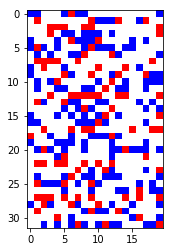

Missing(%) :  0.6


In [541]:
Mask = np.random.rand(M, N) < 0.4
Y = Y_full.copy()
Y[Mask==False] = np.nan
plt.imshow(Y, cmap='bwr')
plt.show()

print('Missing(%) : ', np.sum(1-Mask)/(N*M))

The following function implements an alternating gradient ascent algorithm for Logistic Matrix Factorization

In [548]:
def LogisticMF(Y, K, Mask, eta=0.005, nu=0.1, MAX_ITER = 5000, PRINT_PERIOD=500):
    M = Y.shape[0]
    N = Y.shape[1]
    
    W = np.random.randn(M,K)
    H = np.random.randn(K,N)
    
    YM = Y.copy()
    YM[Mask==False] = 0

    
    for epoch in range(MAX_ITER):
        dLh = np.dot(W.T, YM-Mask*sigmoid(np.dot(W,H))) - nu*H
        H = H + eta*dLh
        dLw = np.dot(YM-Mask*sigmoid(np.dot(W,H)),H.T ) - nu*W
        W = W + eta*dLw

        if epoch % PRINT_PERIOD == 0:
            LL = np.sum( (YM*np.log(sigmoid(np.dot(W,H))) +  (Mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))) ) - nu*np.sum(H**2)/2. - nu*np.sum(W**2)/2. 
            print(epoch, LL)
        
    return W,H


In [554]:
W, H = LogisticMF(Y, K=2, Mask=Mask, MAX_ITER = 50000, PRINT_PERIOD=10000)

thr = 0.5

fig=plt.figure(figsize=(12, 6))
plt.subplot(1,5,1)
plt.imshow(Y_full, cmap='bwr', vmin=0, vmax=1)
plt.subplot(1,5,2)
plt.imshow(Y, cmap='bwr', vmin=0, vmax=1)
plt.subplot(1,5,3)
Y_pred = sigmoid(W.dot(H))
plt.imshow(Y_pred, cmap='bwr', vmin=0, vmax=1)
ax = plt.subplot(1,5,4)
Y_rec = Y_pred > thr
plt.imshow(Y_rec, cmap='bwr', vmin=0, vmax=1)
ax2 = plt.subplot(1,5,5)
plt.imshow(Y_full - Y_rec, cmap='PiYG', vmin=-1, vmax=1)
#plt.show()
plt.close(fig)

def change_thr(thr):
    ax.cla()
    Y_rec = Y_pred > thr
    ax.imshow(Y_rec, cmap='bwr', vmin=0, vmax=1)
    ax2.imshow(Y_full - Y_rec, cmap='PiYG', vmin=-1, vmax=1)
    #plt.show()
    display(fig)

interact(change_thr, thr=(0.0, 1.0,0.01))

#change_thr(0.01)

0 -243.353852116
10000 -56.7876652915
20000 -56.7876486994
30000 -56.7876486994
40000 -56.7876486994


interactive(children=(FloatSlider(value=0.5, description='thr', max=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.change_thr>

In [555]:
def evaluate_results(target=target, probabilities=Y_pred, thr=0.5):
    estimate = probabilities > thr

    conf_matrix = {'TP': 0, 'TN': 0, 'FP':0, 'FN': 0}

    for i in range(len(target)):
        if target[i]==True and estimate[i]==True:
            conf_matrix['TP'] += 1
        elif target[i]==True and estimate[i]==False:
            conf_matrix['FN'] += 1
        elif target[i]==False and estimate[i]==False:
            conf_matrix['TN'] += 1
        elif target[i]==False and estimate[i]==True:
            conf_matrix['FP'] += 1

    num_correct = conf_matrix['TP']+conf_matrix['TN']
    num_total = target.shape[0]
    Accuracy = num_correct/num_total
    if conf_matrix['TP']+conf_matrix['FP']>0:
        Precision = conf_matrix['TP']/(conf_matrix['TP']+conf_matrix['FP'])
    else:
        Precision = 0
    if conf_matrix['TP']+conf_matrix['FN']>0:
        Recall = conf_matrix['TP']/(conf_matrix['TP']+conf_matrix['FN'])
    else:
        Recall = 0
    if Precision==0 or Recall==0:
        F1 = 0
    else:
        F1 = 2/(1/Precision + 1/Recall)
        
    if conf_matrix['FP']+conf_matrix['TN']>0:
        FPR = conf_matrix['FP']/(conf_matrix['TN']+conf_matrix['FP'])
    else:
        FPR = 0
        
    return conf_matrix, {'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1': F1, 'FPR': FPR}
        
def evaluate(thr):
    Y_pred = sigmoid(W.dot(H))[Mask==False]
    target = Y_full[Mask==False]
    conf_matrix, res = evaluate_results(target=target, probabilities=Y_pred, thr=thr)
    
    print('Accuracy  : ', res['Accuracy'])
    print('Precision : ', res['Precision'])
    print('Recall    : ', res['Recall'])
    print('F1        : ', res['F1'])
    print('TPR       : ', res['Recall'])
    print('FPR       : ', res['FPR'])
    print(conf_matrix)

def roc_curve():
    Y_pred = sigmoid(W.dot(H))[Mask==False]
    target = Y_full[Mask==False]
    th = np.linspace(0,1,200)
    fpr = []
    tpr = []
    for i in range(len(th)):
        conf_matrix, res = evaluate_results(target=target, probabilities=Y_pred, thr=th[i]) 
        fpr.append(res['FPR'])
        tpr.append([res['Recall']])

    return fpr, tpr


interact(evaluate, thr=(0.0, 1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='thr', max=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.evaluate>

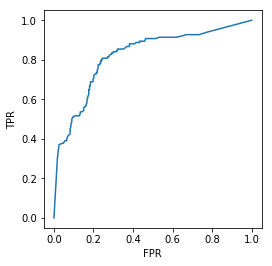

In [556]:
fpr, tpr = roc_curve()

plt.figure()
plt.plot(fpr, tpr, '-')
plt.axis('square')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

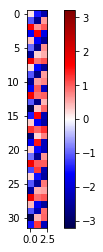

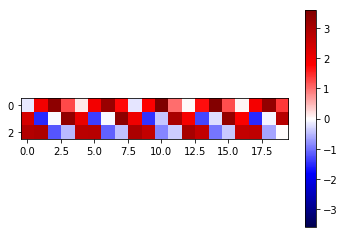

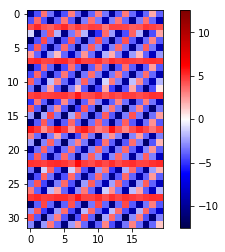

In [493]:
color_lim = np.max(np.abs(W)) 
plt.imshow(W, 'seismic', vmin=-color_lim, vmax=color_lim)
plt.colorbar()
plt.show()
color_lim = np.max(np.abs(H)) 
plt.imshow(H, 'seismic', vmin=-color_lim, vmax=color_lim)
plt.colorbar()
plt.show()
Theta_hat = W.dot(H)
color_lim = np.max(np.abs(Theta_hat)) 
plt.imshow(Theta_hat, 'seismic', vmin=-color_lim, vmax=color_lim)
plt.colorbar()
plt.show()

## The likelihood function

\begin{eqnarray}
p(Y |W, H ) &=& \prod_j \left(\left(\prod_{i : Y(i,j)=1} \sigma(\sum_k W(i,k) H(k,j)) \right) \left(\prod_{i : Y(i,j)=0}(1- \sigma\left((\sum_k W(i,k) H(k,j))\right) \right) \right)
\end{eqnarray}

\begin{eqnarray}
\log p(Y |W, H ) &=& \sum_j \sum_{i : Y(i,j)=1} \log \sigma\left(\sum_k W(i,k) H(k,j)\right) + \sum_j \sum_{i : Y(i,j)=0} \log\left(1- \sigma(\sum_k W(i,k) H(k,j))\right) \\
\end{eqnarray}

\begin{eqnarray}
\log \sigma(x) & = & -\log(1+e^{-x}) = x - \log(1+e^{x}) \\
\log(1 - \sigma(x)) & = &  -\log({1+e^{x}})
\end{eqnarray}

Using the above properties of the sigmoid function

\begin{eqnarray}
\log p(Y |W, H ) &=& \sum_j\sum_{i : Y(i,j)=1} \left( \left(\sum_k W(i,k) H(k,j)\right) - \log \left(1 + \exp(\sum_k W(i,k) H(k,j))\right) \right) - \sum_j \sum_{i : Y(i,j)=0} \log\left( 1+ \exp\left(\sum_k W(i,k) H(k,j) \right)\right) \\
&=& \sum_j \sum_{i} Y(i,j) \left(\sum_k W(i,k) H(k,j)\right)  - \sum_j \sum_{i} \log\left( 1+\exp\left(\sum_k W(i,k) H(k,j)\right)\right) 
\end{eqnarray}

With missing values given as a mask matrix $M(i,j)$.

\begin{eqnarray}
\log p(Y |W, H ) &=& \sum_j \sum_{i} M(i,j) Y(i,j) \left(\sum_k W(i,k) H(k,j)\right)  - \sum_j \sum_{i} M(i,j) \log\left( 1+ \exp\left(\sum_k W(i,k) H(k,j)\right)\right) 
\end{eqnarray}

\begin{eqnarray}
\frac{\partial}{\partial W(i,k)} \log p(Y |W, H ) &=& \sum_j M(i,j) Y(i,j) H(k,j)  - \sum_j M(i,j) \sigma\left(\sum_k W(i,k) H(k,j)\right) H(k, j) \\
&=& \sum_j M(i,j) \left(Y(i,j) - \sigma\left(\sum_k W(i,k) H(k,j)\right) \right) H(k, j)
\end{eqnarray}

\begin{eqnarray}
\frac{\partial}{\partial H(k,j)} \log p(Y |W, H ) &=& \sum_i M(i,j) Y(i,j) W(i,k)  - \sum_j M(i,j) \sigma\left(\sum_k W(i,k) H(k,j)\right) W(i, k) \\
&=& \sum_j M(i,j) \left(Y(i,j) - \sigma\left(\sum_k W(i,k) H(k,j)\right) \right) W(i, k)
\end{eqnarray}


#### Evaluating the gradient (In matrix notation)

$$
\frac{d\mathcal{L}(W,H)}{dW} = (M \odot (Y -\sigma(W H)))H^\top
$$

$$
\frac{d\mathcal{L}(W,H)}{dH} = W^\top (M \odot (Y -\sigma(W H)))
$$

In [163]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt


# Generate a random logistic regression problem

def sigmoid(t):
    return 1./(1+np.exp(-t))

M = 3
N = 2
K = 1

# Some random parameters
W_true = np.random.randn(M,K)
H_true = np.random.randn(K,N)

# Generate class labels
pi = sigmoid(np.dot(W_true, H_true))
Y = np.array(pi<np.random.rand(M,N),dtype=float)

#Mask = np.ones((M,N))
p_miss = 0.
Mask = np.array(p_miss<np.random.rand(M,N),dtype=float)

Mask_nan = Mask.copy()
Mask_nan[Mask==0] = np.nan

0 -284.11399162
500 -30.9194646692
1000 -25.1022660375
1500 -24.0551460711
2000 -23.5543573338
2500 -23.2639426685
3000 -23.0842643527
3500 -22.9703584225
4000 -22.8973305749
4500 -22.8501706001


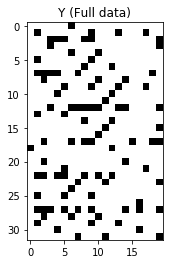

ValueError: operands could not be broadcast together with shapes (32,20) (20,100) 

In [547]:

W, H = LogisticMF(Y, K, Mask)

plt.imshow(Y, interpolation='nearest', cmap=plt.cm.gray_r)  
plt.title('Y (Full data)')
plt.show()
plt.imshow(Y*Mask_nan, interpolation='nearest')  
plt.title('Mask*Y (Observed data)')
plt.show()
plt.imshow(sigmoid(np.dot(W,H)), interpolation='nearest')  
plt.title('\sigma(W*H)')
plt.show()

plt.imshow(sigmoid(np.dot(W_true,H_true)), interpolation='nearest')  
plt.title('\sigma(W_true*H_true)')
plt.show()
plt.imshow(W, interpolation='nearest') 
plt.title('W')
plt.show()
plt.imshow(H, interpolation='nearest')  
plt.title('H')
plt.show()

0 -977.378112433 -962.352408243
20000 -7.38057656109 -92.4606913662
40000 -7.20907297677 -54.2734373234
60000 -7.18177626411 -41.6629650894
80000 -7.17495234995 -39.3866079522
100000 -7.17320756674 -39.3470580283
120000 -7.17270553515 -39.574801569
140000 -7.17252545358 -39.7566530183
160000 -7.17244765846 -39.862447159
180000 -7.1724087816 -39.9099601681
200000 -7.17238682159 -39.9198281508
220000 -7.17237311512 -39.907473797
240000 -7.17236390064 -39.8830932586
260000 -7.17235738569 -39.8530623593
280000 -7.17235263031 -39.8212250004
300000 -7.17234909242 -39.7898151636
320000 -7.17234643139 -39.7600647402
340000 -7.17234441794 -39.7325910257
360000 -7.17234288988 -39.707640191
380000 -7.17234172867 -39.6852392403
400000 -7.17234084593 -39.6652904469
420000 -7.172340175 -39.6476297409
440000 -7.17233966527 -39.6320624926
460000 -7.17233927823 -39.6183851071
480000 -7.17233898452 -39.606397705


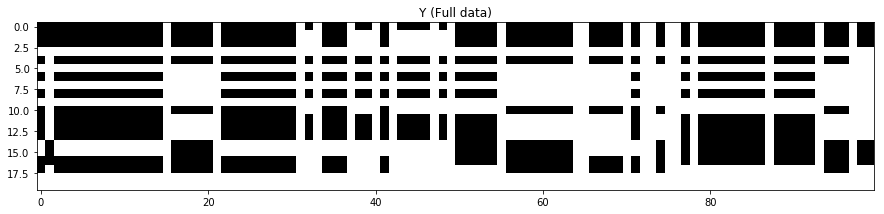

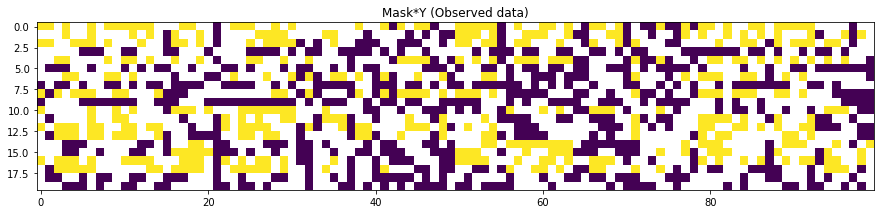

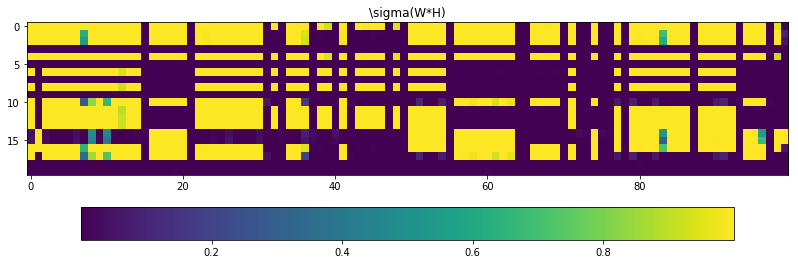

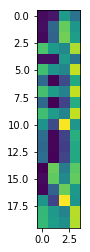

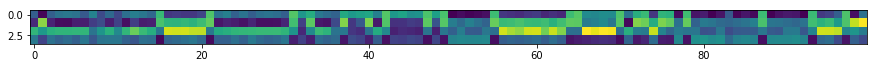

In [165]:

def binary_random_mask_generator(M=30, N=150, p_miss=0.2):
    Mask = np.array(np.random.rand(M,N)>p_miss,dtype=float)

    Mask_nan = Mask.copy()
    Mask_nan[Mask==0] = np.nan
    
    return Mask, Mask_nan
    
def binary_random_matrix_generator1(M=30, N=150, p_on=0.3, p_switch=0.25):
    Y = np.zeros((M,N))
    y = np.array(np.random.rand(M,1)<p_on, dtype=float)
    for i in range(N):
        if np.random.rand()<p_switch:
            y = np.array(np.random.rand(M,1)<p_on, dtype=float)

        Y[:,i] = y.reshape(1,M)
    
    return Y

# Generate a catalog and reuse these
def binary_random_matrix_generator2(R=10, M=30, N=150, p_on=0.3, p_switch=0.25):
    Y = np.zeros((M,N))
    Catalog = np.array(np.random.rand(M,R)<p_on, dtype=float)
    idx = np.random.choice(range(R))
    for i in range(N):
        if np.random.rand()<p_switch:
            idx = np.random.choice(range(R))

        Y[:,i] = Catalog[:,idx].reshape(1,M)
    
    return Y

# Generate a catalog and reuse pairwise
def binary_random_matrix_generator3(R=10, M=30, N=150, p_on=0.3, p_switch=0.25):
    Y = np.zeros((M,N))
    Catalog = np.random.rand(M,R)<p_on
    
    sz = 2
    
    idx = np.random.choice(range(R), size=sz, replace=True)
    y = np.ones((1,M))<0
    for i in range(sz): 
        y = np.logical_or(y, Catalog[:,idx[i]])
    
    for i in range(N):
        if np.random.rand()<p_switch:
            idx = np.random.choice(range(R), size=sz, replace=True)
            y = np.ones((1,M))<0
            for i in range(sz): 
                y = np.logical_or(y, Catalog[:,idx[i]])
                
        Y[:,i] = y.reshape(1,M)    
    return Y

M = 20
N = 100

# Rank
K = 4

#Y = binary_random_matrix_generator1(M=M, N=N)
Y = binary_random_matrix_generator3(M=M, N=N, R=3)
Mask, Mask_nan = binary_random_mask_generator(M=M, N=N, p_miss=0.5)

W, H = LogisticMF(Y, K, Mask, eta=0.003, nu = 0.01, MAX_ITER=500000, PRINT_PERIOD=20000)

figsz = (15,4)
plt.figure(figsize=figsz)
plt.imshow(Y, interpolation='nearest', cmap=plt.cm.gray_r)  
plt.title('Y (Full data)')
plt.show()
plt.figure(figsize=figsz)
plt.imshow(Y*Mask_nan, interpolation='nearest')  
plt.title('Mask*Y (Observed data)')
plt.show()

    
plt.figure(figsize=figsz)
plt.imshow(sigmoid(np.dot(W,H)), interpolation='nearest')  
plt.title('\sigma(W*H)')
plt.colorbar(orientation='horizontal')
plt.show()
#plt.figure(figsize=figsz)
plt.imshow(W, interpolation='nearest')  
plt.show()
plt.figure(figsize=figsz)
plt.imshow(H, interpolation='nearest')  
plt.show()


# Binary relationships

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd


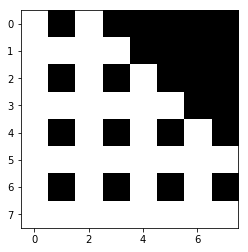

0 -56.4227571078 0.0
500 -9.09378505543 0.0
1000 -7.74362968188 0.0
1500 -7.62390149964 0.0
2000 -7.57196567088 0.0
2500 -7.53889652283 0.0
3000 -7.51610291795 0.0
3500 -7.5002162736 0.0
4000 -7.48917805222 0.0
4500 -7.48156842175 0.0
5000 -7.4763896269 0.0
5500 -7.47292475638 0.0
6000 -7.47064894088 0.0
6500 -7.46917947102 0.0
7000 -7.46824402365 0.0
7500 -7.46765498943 0.0
8000 -7.46728703037 0.0
8500 -7.46705847139 0.0
9000 -7.46691706597 0.0
9500 -7.46682982688 0.0
10000 -7.46677611371 0.0
10500 -7.46674309102 0.0
11000 -7.46672281092 0.0
11500 -7.46671036665 0.0
12000 -7.46670273543 0.0
12500 -7.46669805802 0.0
13000 -7.46669519218 0.0
13500 -7.46669343682 0.0
14000 -7.46669236188 0.0
14500 -7.46669170375 0.0
15000 -7.46669130086 0.0
15500 -7.46669105426 0.0
16000 -7.46669090332 0.0
16500 -7.46669081095 0.0
17000 -7.46669075442 0.0
17500 -7.46669071983 0.0
18000 -7.46669069866 0.0
18500 -7.46669068571 0.0
19000 -7.46669067779 0.0
19500 -7.46669067294 0.0


In [176]:
M = 8
L = 2

A = np.zeros((M,M,L))
Mask = np.ones((M,M))
for i in range(M):
    for j in range(M):
        k = ((i+1)*j)%L | int(j>i+2)
        #k = 1 if i==j else 0 
        A[i,j,k] = 1

Y = A[:,:,1]
plt.imshow(Y, cmap='gray_r')
plt.show()

W, H = LogisticMF(Y, K=4, Mask=Mask, MAX_ITER = 20000)


When $K=5$

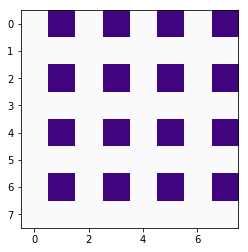

In [173]:
plt.imshow(sigmoid(W.dot(H)), cmap='Purples', vmin=0, vmax=1)
plt.show()


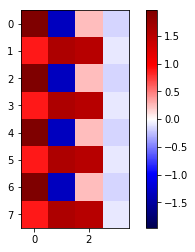

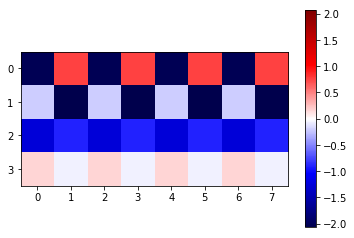

In [174]:
color_lim = np.max(np.abs(W)) 
plt.imshow(W, 'seismic', vmin=-color_lim, vmax=color_lim)
plt.colorbar()
plt.show()
color_lim = np.max(np.abs(H)) 
plt.imshow(H, 'seismic', vmin=-color_lim, vmax=color_lim)
plt.colorbar()
plt.show()

In [160]:
from numpy.random import randn
from numpy.linalg import norm
from numpy.linalg import qr

def subspace_iteration(X, K=1, verbose=False, EPOCH = 40, correct_signs=True):
    M, N = X.shape
    
    u = randn(M,K)
    v = randn(N,K)
    u,dummy = qr(u)
    v,dummy = qr(v)

    for e in range(EPOCH):
        lam = u.T.dot(X).dot(v)
        u = X.dot(v)
        u,dummy = qr(u)
        v = u.T.dot(X).T
        v,dummy = qr(v)
        if verbose:
            if e%10==0:
                print(lam)
        
    if correct_signs:
        signs = np.sign(np.diag(lam))
        return -signs*u, signs*lam, v
    else:
        return u, lam, v

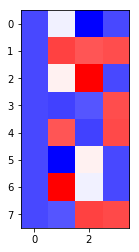

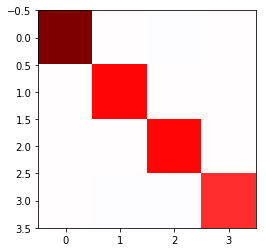

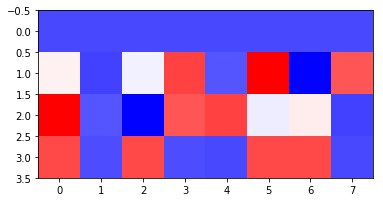

In [161]:
# For visualization of real matrices, it is best to use a diverging colormap where zero is
# mapped to white, with 
U,S,V = subspace_iteration(W.dot(H), K=H.shape[0])
plt.imshow(U,cmap='seismic', vmin=-1, vmax=1)
#plt.colorbar()
plt.show()
color_lim = np.abs(S[0,0])
plt.imshow(S,cmap='seismic', vmin=-color_lim, vmax=color_lim)
#plt.colorbar()
plt.show()
plt.imshow(V.T,cmap='seismic', vmin=-1, vmax=1)
#plt.colorbar()
plt.show()
